<a href="https://colab.research.google.com/github/fbelinchon/Basic_NeuralNet/blob/main/03_backprop_MIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The forward and backward passes

In [ ]:
#drive.flush_and_unmount()

In [1]:
#| default_exp training

In [3]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [4]:
!pwd

/content


In [6]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F


In [7]:

import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
from pathlib import Path
from torch import tensor,nn,optim
import torch.nn.functional as F
from fastcore.test import test_close
from matplotlib import pyplot as plt
import pdb
from tqdm import tqdm
torch.manual_seed(42)

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

path_data = Path('/content/data/MyDrive/data/')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f:
     ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Foundations version

### Basic architecture

In [ ]:
n,m = x_train.shape # 50000 ejemplos, cada ejemplo con 784 pixel (28x28)
c = y_train.max()+1 # 10 valores, de 0-9
n,m,c

(50000, 784, tensor(10))

In [ ]:
# num hidden
nh = 50

## Definimos los funciones básicas
1. Primero generamos los pesos y los terminos bias. Los pesos se definen como números aleatorios y los términos bias con ceros.

In [ ]:
w1 = torch.randn(m,nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)
b2 = torch.zeros(1)

2. Creamos la función para caluclar la transformación lineal.

In [ ]:
def linT(X,W,b): return X@W +b

In [ ]:
# comprobación
Xt =tensor([[1,2,3],[2,3,4]])
Wt = tensor([[2,2,2]])
bt = tensor([1])
zt=linT(Xt,Wt.T,bt)

test_close(zt, tensor([[13,19]]).T, eps=0.01)

3. Función de error MSE and RELU


In [ ]:
def mse(Z,y):
    return (Z.squeeze() - y).pow(2).mean()

In [ ]:
# Comprobación
Xt =tensor([[1,2,3],[2,3,4]])
Wt = tensor([[2,2,2]])
bt = tensor([1])

yt=tensor([12.2,18.4])
zt=linT(Xt,Wt.T,bt)

test_close(zt, tensor([[13,19]]).T, eps=0.01)
#0.8^2+0.6^2=0.64+0.36=1 la media es 0.5
mse(zt,yt)
test_close(mse(zt,yt),0.5)

4. Función RELU

In [ ]:
def relu(X):
    return torch.clamp(X,min=0)


In [ ]:
#Comprobar
d=tensor([[-.4,5],[4,-5.6]])
relu(d)
test_close(relu(d),tensor([[0.,5],[4.,0.]]))

 5. Modelo

In [ ]:
def modelo(X,y):
     l1=linT(X,w1,b1)
     rl=relu(l1)
     l2=linT(rl,w2,b2)
     return l2

In [ ]:
# comprobación
modelo(x_train,y_train).shape
test_close(modelo(x_train,y_train).shape,[50000,1])

# Forward and backward

Forward

In [ ]:
def forward(X,y):
    l1=linT(X,w1,b1)
    rl=relu(l1)
    out=linT(rl,w2,b2)
    return mse(out,y)

In [ ]:
forward(x_train,y_train)

tensor(4308.76)

Backward

In [ ]:
import pdb

In [ ]:
def lin_grad(input, output,W,b):

    #pdb.set_trace()
    input.g = output.g @ W.T  # 50000x784
    #W.g = input.unsqueeze(-1) * output.g.unsqueeze(1).sum(0) # 784x50 MIRAR
    W.g = input.T @ output.g
    b.g= output.g.sum(0) # OK


In [ ]:
import pdb
def fordward_backward(X,y):
    l1=linT(X,w1,b1)
    rl=relu(l1)
    l2=linT(rl,w2,b2)
    loss=mse(l2,y)


    #backward
    n=X.shape[0]
    #
    l2.g = (2.)*(l2 - y.unsqueeze(-1))/n
    lin_grad(rl,l2,w2,b2)
    l1.g = (l1>0).float() * rl.g
    #pdb.set_trace()
    lin_grad(X,l1,w1,b1)




In [ ]:
#fordward_backward(x_train[:5000,:],y_train[:5000])

In [ ]:
fordward_backward(x_train,y_train)

In [ ]:
# Save for testing against later
torch.Tensor.g = []
def get_grad(x: tensor): return tensor(x.g).clone()
chks = w1,w2,b1,b2,x_train
grads = w1g,w2g,b1g,b2g,ig = tuple(map(get_grad, chks))

<ipython-input-23-5382e8771bbf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  def get_grad(x: tensor): return tensor(x.g).clone()


In [ ]:
def mkgrad(x): return x.clone().requires_grad_(True)
ptgrads = w12,w22,b12,b22,xt2 = tuple(map(mkgrad, chks))

In [ ]:
def forward(inp, targ):
    l1 = linT(inp, w12, b12)
    l2 = relu(l1)
    out = linT(l2, w22, b22)
    return mse(out, targ)

In [ ]:
loss = forward(xt2, y_train)
loss.backward()

In [ ]:
for a,b in zip(grads, ptgrads): test_close(a, b.grad, eps=0.01)

# forward pass:
    l1 = linT(inp, w1, b1)
    l2 = relu(l1)
    out = linT(l2, w2, b2)
    diff = out[:,0]-targ
    loss = diff.pow(2).mean()



    # backward pass:
    out.g = 2.*diff[:,None] / inp.shape[0]
    lin_grad(l2, out, w2, b2)
    l1.g = (l1>0).float() * l2.g
    lin_grad(inp, l1, w1, b1)

### Gradients and backward pass

In [ ]:
from sympy import symbols,diff
x,y = symbols('x y')
diff(x**2, x)

2*x

In [ ]:
diff(3*x**2+9, x)

6*x

In [ ]:
diff(x**2+3*x**3*y-4*x*y**2,x) # derivado con respecto a x

9*x**2*y + 2*x - 4*y**2

In [ ]:
diff(x**2+3*x**3*y-4*x*y**2,y) # derivada con respecto a y

3*x**3 - 8*x*y

### Layers as classes

Creamos la Clase para la función RELU:
* En la llamada `__call__` almacenamos la salida self.output
* Calculamos el gradiente de esta estapa.

El gradiente de una etapa se caluca utilizando chain rule. El gradiente de la entrada se calcula como el gradiente de la función con respecto a la entrada  por el gradiente de la salida (el gradiente de la salida se ha calculado en la etapa anterior)
d_Loss/d_inp = d_Loss/d_out * d_out/d_inp


In [ ]:
class Relu():
    def forward(self,inp):
        self.inp = inp
        self.out = inp.clamp_min(0.)
        return self.out

    def backward(self):
        # (self.inp>0).float() -> tensor([1., 0., 1.,....])
        pdb.set_trace()
        self.inp.g = self.out.g * (self.inp > 0).float() # d_Loss/d_out * d_out/d_int


Clase Lin \

1. Constructor (w,b)
2. Llamada a la clase: pasamos inp y realiza la función lineal `out= inp@w + b`
3. Calculamos gradientes de inp, x y b

Gradiente de inp: dLoss/d_inp = dLoss/d_out * d_out/d_inp => out.g @ W \
Gradiente de w: dLoss/d_w = dLoss/d_out * d_out/d_w => inp.T @ out.g \
Gradiente de b: dLoss/d_w = dLoss/d_out * d_out/d_b =>out.g.sum(0)


In [ ]:
class Lin():
    def __init__(self,m,nh):
        self.w = torch.randn(m,nh)
        self.b = torch.zeros(nh)

    def forward(self,inp):
        #pdb.set_trace()
        self.inp=inp
        self.out = self.inp @ self.w + self.b.unsqueeze(0)
        return self.out

    def backward(self):
        self.inp.g = self.out.g @ self.w.T
        self.w.g = self.inp.T @ self.out.g
        self.b.g = self.out.g.sum(0)

Clase MSE
1. llamada para calcular MSE: (inp-y)^2.mean()
2. calculamos el gradiente de inp

Gradiente con respecto a inp D_Loss/d_inp = 2/n * (i-y)



In [ ]:
class Mse():
    def __call__(self,inp,y):
        self.inp,self.y = inp,y
        self.out = ((self.inp - self.y.unsqueeze(-1)).pow(2)).mean()
        return self.out

    def backward(self):

        self.inp.g = 2.0 * (self.inp - self.y.unsqueeze(-1)) / self.y.shape[0]

Clase Modelo
1. `__init__`
2. fordward
3. backward

In [ ]:
from logging import exception
class Modelo():
    def __init__(self,ninp,nh,nout):
        self.layers=[Lin(ninp,nh),Relu(),Lin(nh,nout)]
        self.loss = Mse()

    def __call__(self,x,y):
        out=x

        for layer in self.layers:
            out=layer.forward(out)
        return self.loss(out,y)

    def backward(self):
        self.loss.backward()
        #pdb.set_trace()
        for layer in reversed(self.layers):
            layer.backward()

In [ ]:
model = Modelo(m,nh,1)

In [ ]:
loss = model(x_train, y_train)

In [ ]:
loss

tensor(1549.37)

In [ ]:
model.backward()


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 336, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-32-9b1eda87c417>(10)backward()
      6 
      7     def backward(self):
      8         # (self.inp>0).float() -> tensor([1., 0., 1.,....])
      9         pdb.set_trace()
---> 10         self.inp.g = self.out.g * (self.inp > 0).float() # d_Loss/d_out * d_out/d_int

ipdb> c



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 347, in set_continue
    sys.settrace(None)



In [ ]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

AssertionError: close:
tensor([[    -0.00,     -0.01,      0.00,  ...,     -0.00,      0.00,      0.00],
        [    -0.03,     -0.03,      0.01,  ...,     -0.04,     -0.01,     -0.01],
        [     0.00,      0.00,     -0.00,  ...,      0.00,     -0.00,      0.00],
        ...,
        [    -0.00,     -0.02,      0.01,  ...,     -0.00,     -0.00,      0.00],
        [    -0.02,     -0.01,      0.01,  ...,     -0.01,      0.01,     -0.00],
        [    -0.00,     -0.00,      0.00,  ...,     -0.00,     -0.00,     -0.00]])
tensor([[ 0.00, -0.01, -0.01,  ..., -0.01,  0.00, -0.00],
        [-0.00,  0.00,  0.01,  ..., -0.00, -0.00, -0.00],
        [ 0.01,  0.00, -0.02,  ...,  0.00,  0.00,  0.00],
        ...,
        [ 0.00,  0.01, -0.01,  ...,  0.00,  0.01,  0.02],
        [ 0.01, -0.00, -0.01,  ..., -0.00,  0.00,  0.01],
        [ 0.00, -0.00, -0.00,  ..., -0.01,  0.00,  0.02]])

### Creamos la clase Module para que hereden el resto de capas.

In [ ]:
class Module():
    def __call__(self, *args):
        self.args = args   # lista de argumentos pasados en la llamada __cal__. Almacena los parmátros de entrada
        #pdb.set_trace()
        self.out = self.forward(*args)  # Almacena el parámetro de salida ejecutando fordward con los parámetros de entrada
        #pdb.set_trace()
        return self.out

    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)
    def bwd(self): raise Exception('not implemented')

In [ ]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)
    def bwd(self, out,inp ):
        #pdb.set_trace()
        inp.g = (inp>0).float() * out.g

In [ ]:
class Lin(Module):
    def __init__(self, ninp, nout):
        self.w = torch.randn(ninp,nout)
        self.b = torch.zeros(nout)

    def forward(self, inp):
        return inp@self.w + self.b
    def bwd(self, out, inp):
        inp.g = self.out.g @ self.w.t()

        self.w.g = inp.t() @ self.out.g
        self.b.g = self.out.g.sum(0)

In [ ]:
class Mse(Module):
    def forward (self, inp, targ):
        #pdb.set_trace()
        return (inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ):

        inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]

In [ ]:
class Modelo():
    def __init__(self,m,nh,nout):
        self.layers=[Lin(m,nh),Relu(),Lin(nh,nout)]
        self.loss = Mse()

    def __call__(self,x,y):


        for layer in self.layers:
            x=layer(x)

        return self.loss(x,y)

    def backward(self):
        self.loss.backward()
        #pdb.set_trace()
        for layer in reversed(self.layers):
            layer.backward()

In [ ]:
model = Modelo(m,50,1)

In [ ]:
loss = model(x_train, y_train)

In [ ]:
loss

tensor(744.75)

In [ ]:
model.backward


<bound method Modelo.backward of <__main__.Modelo object at 0x7ea9918ec1c0>>

In [ ]:
from tqdm import tqdm

In [ ]:
lr=0.05
epochs = 3
bs = 128
model = Modelo(m,nh,1)

In [ ]:
model(x_train[0:2],y_train[0:2])

tensor(331.52)

In [ ]:
model = Modelo(m,50,1)

In [ ]:
for epoch in range(epochs):

    eloss=0.
    for i in tqdm(range(0,n,bs)):

        x = x_train[i:(i+min(bs,(n-i)))]
        y = y_train[i:(i+min(bs,(n-i)))]


        loss = model(x, y)
        eloss+=loss
        model.backward()

        #print(loss)

        with torch.no_grad():
            #pdb.set_trace()
            model.layers[0].w -= lr * model.layers[0].w.g
            model.layers[0].b -= lr * model.layers[0].b.g
            model.layers[2].w -= lr * model.layers[2].w.g
            model.layers[2].b -= lr *model.layers[2].b.g



    print(f'epoch {epoch}: loss {eloss/min(bs,(n-i))}\n')

100%|██████████| 391/391 [00:00<00:00, 859.09it/s]


epoch 0: loss 23352650.0



100%|██████████| 391/391 [00:00<00:00, 788.52it/s]


epoch 1: loss 40.87119674682617



100%|██████████| 391/391 [00:00<00:00, 897.46it/s]

epoch 2: loss 40.87119674682617



### Autograd

Usamos pytorch para generar el mismo código. \
Pytorch ya tiene la clase Module implementada.

En este caso vamos a iniciar los pesos dentro del init de la clase Linear. Solamente tenemos que indicar las dimensiones.

No tenemos que utilizar backward porque de eso se ancarga directamente Pytorch

In [ ]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [ ]:
from torch import nn
import torch.nn.functional as F

In [ ]:
class Linear(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.w = torch.randn(n_in,n_out).requires_grad_()
        self.b = torch.zeros(n_out).requires_grad_()
    def forward(self, x):
        #pdb.set_trace()
        return x@self.w + self.b

In [ ]:
class Modelo(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [Linear(n_in,nh), nn.ReLU(), Linear(nh,n_out)]

    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [ ]:
model = Modelo(m,nh,c)
pred = model(x_train)
assert (list(pred.shape) == [50000,10])

## Cross entropy loss

In [ ]:
def softmax(x):
    return x.exp()/x.exp().sum(-1,keepdim=True) # keepdim mantiene la dimensión y permite sumar solamente la columna


In [ ]:
x=[[1,2],[3,8],[7,10],[2.1,2.3]]
x=tensor(x)
a=softmax(x)
torch.ones(a.shape[-1])

a.sum(-1).shape
test_close(a.sum(-1),torch.ones(a.shape[0]))

In [ ]:
def log_softmax(x):
    return (x.exp()/x.exp().sum(-1,keepdim=True)).log() # keepdim mantiene la dimensión y permite sumar solamente la columna


In [ ]:
log_softmax(x)

tensor([[-1.31, -0.31],
        [-5.01, -0.01],
        [-3.05, -0.05],
        [-0.80, -0.60]])

In [ ]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [ ]:
log_softmax(x)

tensor([[-1.31, -0.31],
        [-5.01, -0.01],
        [-3.05, -0.05],
        [-0.80, -0.60]])

# Basic training loop

## variables básica

In [ ]:
from torch import nn,tensor

In [ ]:
epochs=8
bs=128
lr=.01
nh=50
m,n=x_train.shape[0],x_train.shape[1]

o=10

In [ ]:
assert (n,nh,o)==(784,50,10)

## Definición del modelo

In [ ]:
class Modelo(nn.Module):
    def __init__(self,n,nh,o):
        super().__init__()
        self.layers=[nn.Linear(n,nh),nn.ReLU(),nn.Linear(nh,o)]

    def forward(self,x):
        for layer in self.layers:
            x=layer(x)
        m = nn.LogSoftmax(dim=1)
        return m(x)

In [ ]:

model=Modelo(n,nh,o)
model(x_train[0:4])

tensor([[-2.17, -2.23, -2.23, -2.49, -2.30, -2.37, -2.35, -2.35, -2.20, -2.39],
        [-2.15, -2.20, -2.19, -2.54, -2.22, -2.36, -2.32, -2.34, -2.30, -2.49],
        [-2.26, -2.30, -2.21, -2.52, -2.30, -2.39, -2.16, -2.30, -2.24, -2.40],
        [-2.15, -2.27, -2.28, -2.52, -2.29, -2.45, -2.21, -2.34, -2.24, -2.32]], grad_fn=<LogSoftmaxBackward0>)

In [ ]:
assert model.forward(x_train[0:4]).shape[0] == 4
assert model.forward(x_train[0:4]).shape[1] == 10

## Training Loop

In [ ]:
from torch import nn
loss_func = nn.NLLLoss()

In [ ]:
for epoch in range(epochs):

    error=[]
    accuracy=[]
    for i in range(0,n,bs):
        x = x_train[i:i+min(bs,n-i)]
        y = y_train[i:i+min(bs,n-i)]

        pred = model.forward(x)
        #pdb.set_trace()
        out = loss_func(pred,y)
        error.append(out)
        accuracy.append((pred.argmax(1) == y).sum())

        out.backward()



        with torch.no_grad():
            for layer in model.layers:
                for param in layer.parameters():
                    param -= lr*param.grad
            model.zero_grad()


    print(f'error {sum(error)/len(error):.2f}   /   accuracy {sum(accuracy)/n:.2f}%')


error 2.29   /   accuracy 0.13%
error 2.21   /   accuracy 0.36%
error 2.06   /   accuracy 0.49%
error 1.79   /   accuracy 0.53%
error 1.41   /   accuracy 0.65%
error 1.01   /   accuracy 0.75%
error 0.72   /   accuracy 0.78%
error 0.55   /   accuracy 0.81%


In [ ]:
def accuracy(out, yb):
    return (out.argmax(dim=1)==yb).float().mean().detach()

def report(epoch,loss, preds, yb):
    print(f'epoch: {epoch+1} , loss: {loss:.2f}, acc: {accuracy(preds, yb):.2f}')

In [ ]:
#loss_func = nn.functional.nll_loss

In [ ]:

def fit(epochs,lr):
    for epoch in range(epochs):

        for i in range(0,n,bs):
            s = slice(i,min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            #pdb.set_trace()
            loss = loss_func(preds,yb)
            loss.backward()

            with torch.no_grad():
                for layer in model.layers:
                    for param in layer.parameters():
                        param -= param.grad * lr
                model.zero_grad()
        #pdb.set_trace()
        report(epoch,loss, preds, yb)



In [ ]:
model=Modelo(n,nh,o)
fit(7,0.02)

epoch: 1 , loss: 2.25, acc: 0.31
epoch: 2 , loss: 1.99, acc: 0.44
epoch: 3 , loss: 1.46, acc: 0.44
epoch: 4 , loss: 0.81, acc: 0.81
epoch: 5 , loss: 0.53, acc: 0.81
epoch: 6 , loss: 0.18, acc: 0.94
epoch: 7 , loss: 0.12, acc: 1.00


Usamos Cross entropy loss


In [ ]:
import torch.nn.functional as F

In [ ]:
class MLP(nn.Module):
    def __init__(self,n,nh,o):
        super().__init__()
        self.l1 = nn.Linear(n,nh)
        self.l2 = nn.Linear(nh,o)
        self.relu = nn.ReLU()

    def forward(self,x):
       return self.l2(self.relu(self.l1(x)))

In [ ]:
loss_func = F.cross_entropy

In [ ]:

def fit(epochs,lr):
    for epoch in range(epochs):

        for i in range(0,n,bs):
            s = slice(i,min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            #pdb.set_trace()
            loss = loss_func(preds,yb)
            loss.backward()

            with torch.no_grad():
                for param in model.parameters():
                        param -= param.grad * lr
                model.zero_grad()
        #pdb.set_trace()
        report(epoch,loss, preds, yb)

In [ ]:
model=MLP(n,nh,o)
fit(5,0.5)

epoch: 1 , loss: 1.75, acc: 0.50
epoch: 2 , loss: 1.18, acc: 0.56
epoch: 3 , loss: 0.91, acc: 0.69
epoch: 4 , loss: 0.40, acc: 0.94
epoch: 5 , loss: 0.37, acc: 0.94


In [ ]:

for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [ ]:
model=nn.Sequential(nn.Linear(n,nh), nn.ReLU(), nn.Linear(nh,o))
fit(7,0.5)

epoch: 1 , loss: 1.77, acc: 0.50
epoch: 2 , loss: 1.14, acc: 0.50
epoch: 3 , loss: 0.64, acc: 0.81
epoch: 4 , loss: 0.44, acc: 0.94
epoch: 5 , loss: 0.28, acc: 0.94
epoch: 6 , loss: 0.28, acc: 0.94
epoch: 7 , loss: 0.10, acc: 1.00


## Añadimos optimizador

In [ ]:
class Optimizer():
    def __init__(self,parameters, lr=.5):
        self.parameters = list(parameters)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.parameters:
                p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.parameters:
                p.grad.data.zero_()

In [ ]:
model=nn.Sequential(nn.Linear(n,nh), nn.ReLU(), nn.Linear(nh,o))

In [ ]:
opt = Optimizer(model.parameters(),0.5)

In [ ]:
def fit(epochs):
    for epoch in range(epochs):

        for i in range(0,n,bs):
            s = slice(i,min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            #pdb.set_trace()
            loss = loss_func(preds,yb)
            loss.backward()

            opt.step();
            opt.zero_grad()
        report(epoch,loss, preds, yb)

In [ ]:
fit(5)

epoch: 1 , loss: 0.25, acc: 0.94
epoch: 2 , loss: 0.16, acc: 0.94
epoch: 3 , loss: 0.08, acc: 1.00
epoch: 4 , loss: 0.06, acc: 1.00
epoch: 5 , loss: 0.04, acc: 1.00


usando optimizador de pythorch

In [ ]:
from torch import optim

In [ ]:
def get_model(lr=.5):
    def init_normal(m):
        if type(m) == nn.Linear:
            nn.init.kaiming_normal_(m.weight)
    model = nn.Sequential(nn.Linear(n,nh), nn.ReLU(), nn.Linear(nh,o))
    model.apply(init_normal)
    return model, optim.SGD(model.parameters(),lr=lr)




In [ ]:
model,opt =  get_model()

In [ ]:
epochs=5

In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(epoch,loss, preds, yb)

epoch: 1 , loss: 1.14, acc: 0.59%
epoch: 2 , loss: 0.65, acc: 0.79%
epoch: 3 , loss: 0.42, acc: 0.88%
epoch: 4 , loss: 0.28, acc: 0.94%
epoch: 5 , loss: 0.19, acc: 0.97%


## Dataset y DataLoaders

In [ ]:
def accuracy(out, yb):
    return (out.argmax(dim=1)==yb).float().mean().detach()

def report(epoch,loss, preds, yb):
    print(f'epoch: {epoch+1} , loss: {loss:.2f}, acc: {accuracy(preds, yb):.2f}%')

In [ ]:
bs=50
epochs=5

nh=50
n=x_train.shape[1]
o=10

In [ ]:
def get_model(lr=.5):
    model = nn.Sequential(nn.Linear(n,nh), nn.ReLU(), nn.Linear(nh,o))
    return model, optim.SGD(model.parameters(),lr=lr)

In [ ]:
loss_func = F.cross_entropy

**Dataset**

In [8]:
#|export
class Dataset():
    def __init__(self,x,y):
        self.x,self.y = x,y
    def __len__(self):
        return len(self.x)
    def __getitem__(self,i):
        return self.x[i],self.y[i]

In [ ]:
train_ds,valid_ds = Dataset(x_train,y_train),Dataset(x_valid,y_valid)

In [ ]:
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [ ]:
xb,yb = train_ds[:5]

xb.shape,yb

(torch.Size([5, 784]), tensor([5, 0, 4, 1, 9]))

In [ ]:
model,opt =  get_model()

In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = train_ds[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(epoch,loss, preds, yb)

epoch: 1 , loss: 0.83, acc: 0.71%
epoch: 2 , loss: 0.48, acc: 0.82%
epoch: 3 , loss: 0.35, acc: 0.88%
epoch: 4 , loss: 0.32, acc: 0.91%
epoch: 5 , loss: 0.29, acc: 0.85%


**dataLoader**

In [ ]:
class DataLoader():
    def __init__(self,ds,bs):
        self.ds,self.bs = ds,bs

    def __iter__(self):
        for i in range(0,len(self.ds),self.bs):
            yield self.ds[i: i+self.bs]

In [ ]:
train_ds,valid_ds = Dataset(x_train,y_train),Dataset(x_valid,y_valid)

In [ ]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [ ]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([50, 784]), torch.Size([50]))

tensor(3)

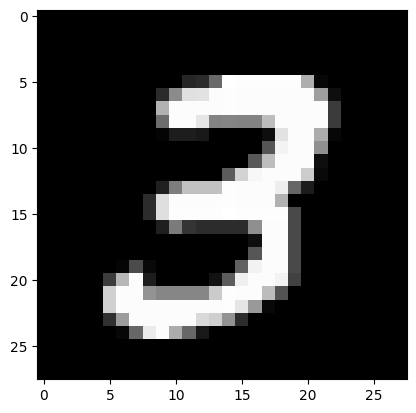

In [ ]:
plt.imshow(xb[7].view(28,28))
yb[7]

In [ ]:
model1,opt1 =  get_model()


In [ ]:
def fit1(epochs):
    for epoch in range(epochs):
        for xb,yb in train_dl:
            #pdb.set_trace()
            preds = model1(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt1.step()
            opt1.zero_grad()
        report(epoch,loss, preds, yb)

In [ ]:
fit1(5)

epoch: 1 , loss: 0.15, acc: 0.94%
epoch: 2 , loss: 0.06, acc: 0.98%
epoch: 3 , loss: 0.07, acc: 0.98%
epoch: 4 , loss: 0.05, acc: 0.98%
epoch: 5 , loss: 0.04, acc: 0.98%


## Pytorch Dataset y DataLoader

In [9]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [ ]:
class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x,self.y = x,y
    def __len__(self):
        return len(self.x)
    def __getitem__(self,i):
        return self.x[i],self.y[i]

In [ ]:
train_ds = MyDataset(x_train[:1000],y_train[:1000])
valid_ds = MyDataset(x_valid,y_valid)

In [ ]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [ ]:
def get_model(lr=.5):
    model = nn.Sequential(nn.Linear(n,nh), nn.ReLU(), nn.Linear(nh,o))
    return model, optim.SGD(model.parameters(),lr=lr)

In [ ]:
model,opt = get_model()
epochs=5

In [ ]:
for epoch in range(epochs):
        for xb,yb in train_dl:
            #pdb.set_trace()
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(epoch,loss, preds, yb)

epoch: 1 , loss: 1.01, acc: 0.68%
epoch: 2 , loss: 0.27, acc: 0.94%
epoch: 3 , loss: 0.40, acc: 0.84%
epoch: 4 , loss: 0.27, acc: 0.92%
epoch: 5 , loss: 0.22, acc: 0.92%


# Añadimos Validación

In [ ]:
num,nh,o = x_train.shape[1],50,10

In [ ]:
train_ds = MyDataset(x_train[:50000],y_train[:50000])
valid_ds = MyDataset(x_valid,y_valid)

train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [ ]:
def get_model(lr=.5):
    model = nn.Sequential(nn.Linear(num,nh), nn.ReLU(), nn.Linear(nh,o))
    return model, optim.SGD(model.parameters(),lr=lr)

In [ ]:
loss_func = F.cross_entropy

In [ ]:
epochs=10
model,opt = get_model(0.15)

In [ ]:
for epoch in range(epochs):
    print(f'Epoch: {epoch}')

    t_loss,t_accu,t_count=0.,0.,0.
    v_loss,v_accu,v_count=0.,0.,0.
    model.train()
    for xb,yb in train_dl:
        n = len(xb)
        t_count += n
        #pdb.set_trace()
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        t_loss += loss_func(preds, yb).item()* n
        t_accu += accuracy(preds,yb).item() * n

    model.eval()
    with torch.no_grad():
        v_loss,v_accu,count=0.,0.,0.
        for xb,yb in valid_dl:
            n = len(xb)
            preds = model(xb)
            v_count += n
            v_loss += loss_func(preds, yb).item()* n
            v_accu += accuracy(preds,yb).item() * n
    print(f'TRAIN: loss: {(t_loss/t_count):.3f}, acc: {(t_accu/t_count):.2f}%' )
    print(f'VALID: loss: {(v_loss/v_count):.3f}, acc: {(v_accu/v_count):.2f}%' )

Epoch: 0
TRAIN: loss: 0.051, acc: 0.98%
VALID: loss: 0.091, acc: 0.97%
Epoch: 1
TRAIN: loss: 0.046, acc: 0.99%
VALID: loss: 0.091, acc: 0.97%
Epoch: 2
TRAIN: loss: 0.042, acc: 0.99%
VALID: loss: 0.091, acc: 0.97%
Epoch: 3
TRAIN: loss: 0.040, acc: 0.99%
VALID: loss: 0.091, acc: 0.97%
Epoch: 4
TRAIN: loss: 0.037, acc: 0.99%
VALID: loss: 0.092, acc: 0.97%
Epoch: 5
TRAIN: loss: 0.033, acc: 0.99%
VALID: loss: 0.092, acc: 0.97%
Epoch: 6
TRAIN: loss: 0.030, acc: 0.99%
VALID: loss: 0.094, acc: 0.97%
Epoch: 7
TRAIN: loss: 0.028, acc: 0.99%
VALID: loss: 0.088, acc: 0.97%
Epoch: 8
TRAIN: loss: 0.026, acc: 0.99%
VALID: loss: 0.093, acc: 0.97%
Epoch: 9
TRAIN: loss: 0.024, acc: 0.99%
VALID: loss: 0.093, acc: 0.98%


In [10]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [11]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [14]:
import nbdev; nbdev.nbdev_export()

InterpolationMissingOptionError: Bad value substitution: option 'lib_name' in section 'DEFAULT' contains an interpolation key 'repo' which is not a valid option name. Raw value: '%(repo)s'

In [13]:
!pip install nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.3 MB/s eta 0:00:00
